In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


Spliting Pedisterian Analysis Dataset into Train/Test/Val part

In [ ]:
import os
import random
import shutil

# Set the root directory containing the folders
root_dir = '/content/drive/MyDrive/DataSets/Pedisterian Analysis Dataset'

# Define the directories for training, testing, and validation sets
train_dir = '/content/drive/MyDrive/DataSets/train'
test_dir = '/content/drive/MyDrive/DataSets/test'
valid_dir = '/content/drive/MyDrive/DataSets/val'

# Set the train-test-valid split ratios
train_ratio = 0.7
test_ratio = 0.2
valid_ratio = 0.1

# Create the directories for train, test, and valid sets
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

# Loop through the folders in the root directory
for folder_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder_name)

    if os.path.isdir(folder_path):
        # Create subdirectories in train, test, and valid sets
        train_folder = os.path.join(train_dir, folder_name)
        test_folder = os.path.join(test_dir, folder_name)
        valid_folder = os.path.join(valid_dir, folder_name)

        os.makedirs(train_folder, exist_ok=True)
        os.makedirs(test_folder, exist_ok=True)
        os.makedirs(valid_folder, exist_ok=True)

        # Get the list of images in the current folder
        image_files = os.listdir(folder_path)
        random.shuffle(image_files)

        # Calculate the number of images for train, test, and valid sets
        num_images = len(image_files)
        num_train = int(num_images * train_ratio)
        num_test = int(num_images * test_ratio)
        num_valid = num_images - num_train - num_test

        # Split the images into train, test, and valid sets
        train_images = image_files[:num_train]
        test_images = image_files[num_train:num_train+num_test]
        valid_images = image_files[num_train+num_test:]

        # Move the images to their respective directories
        for image_file in train_images:
            src_path = os.path.join(folder_path, image_file)
            dst_path = os.path.join(train_folder, image_file)
            shutil.copy(src_path, dst_path)

        for image_file in test_images:
            src_path = os.path.join(folder_path, image_file)
            dst_path = os.path.join(test_folder, image_file)
            shutil.copy(src_path, dst_path)

        for image_file in valid_images:
            src_path = os.path.join(folder_path, image_file)
            dst_path = os.path.join(valid_folder, image_file)
            shutil.copy(src_path, dst_path)


In [ ]:
import os
import cv2
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.color import rgb2hsv
from skimage.feature import hog
from sklearn.decomposition import PCA
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input as preprocess_input_google

In [ ]:
# Set the paths to your data folders
train_folder = '/content/drive/MyDrive/DataSets/train'
test_folder = '/content/drive/MyDrive/DataSets/test'
val_folder = '/content/drive/MyDrive/DataSets/val'

###**PHOG Computation**

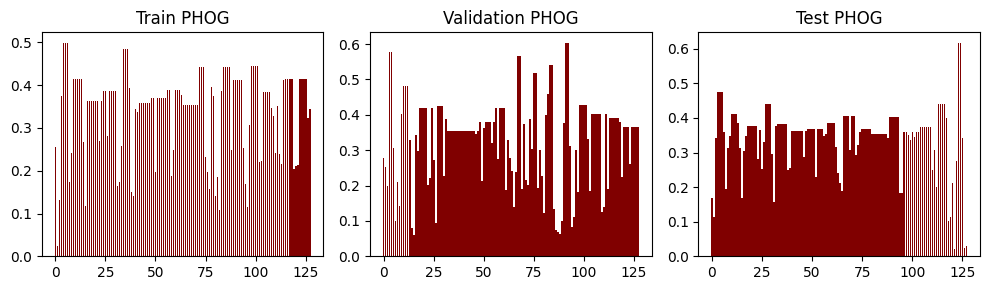

In [ ]:
# Function to compute PHOG features for a given image
def compute_phog(image):
    # Convert image to grayscale if it has more than two dimensions
    if image.ndim > 2:
        image = np.mean(image, axis=2)
    phog_features, _ = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), block_norm='L2-Hys', visualize=True)  # Compute the PHOG features
    return phog_features

# Function to compute PHOG features for all images in a given folder
def compute_phog_folder(folder):
    features = []
    labels = []
    for class_folder in os.listdir(folder):
        class_path = os.path.join(folder, class_folder)
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            image = imread(image_path)
            phog_features = compute_phog(image)
            features.append(phog_features)
            labels.append(class_folder)
    return features, labels

# Compute PHOG features for the training set
phog_train_features, phog_train_labels = compute_phog_folder(train_folder)
phog_train_features = np.array(phog_train_features)
phog_train_labels = np.array(phog_train_labels)

# Compute PHOG features for the test set
phog_test_features, phog_test_labels = compute_phog_folder(test_folder)
phog_test_features = np.array(phog_test_features)
phog_test_labels = np.array(phog_test_labels)

# Compute PHOG features for the validation set
phog_val_features, phog_val_labels = compute_phog_folder(val_folder)
phog_val_features = np.array(phog_val_features)
phog_val_labels = np.array(phog_val_labels)

# Display three random PHOG features
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

# Randomly select indices for the test, train, and validation sets
test_idx = np.random.randint(0, len(phog_test_features))
train_idx = np.random.randint(0, len(phog_train_features))
val_idx = np.random.randint(0, len(phog_val_features))

# Display the train PHOG
train_phog = phog_train_features[train_idx]
axes[0].bar(range(len(train_phog)), train_phog, color='maroon')
axes[0].set_title('Train PHOG')

# Display the validation PHOG
val_phog = phog_val_features[val_idx]
axes[1].bar(range(len(val_phog)), val_phog, color='maroon')
axes[1].set_title('Validation PHOG')

# Display the test PHOG
test_phog = phog_test_features[test_idx]
axes[2].bar(range(len(test_phog)), test_phog, color='maroon')
axes[2].set_title('Test PHOG')

plt.tight_layout()
plt.show()

###**CHF Computation**

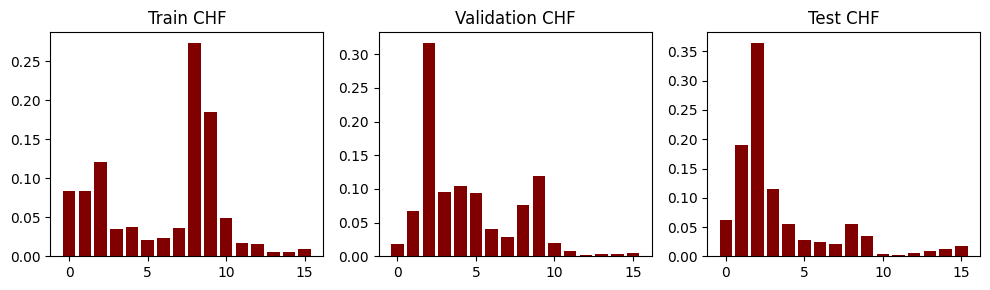

In [ ]:
# Function to compute color histogram features for a given image
def compute_chf(image_path):
    image = imread(image_path)  # Read the image
    image_hsv = rgb2hsv(image)  # Convert the image to HSV color space
    chf, _ = np.histogram(image_hsv[..., 0], bins=16, range=(0, 1))  # Compute the histogram of the hue channel
    chf = chf.astype(np.float64)  # Convert to float64
    chf /= np.sum(chf)  # Normalize the histogram
    return chf

# Function to compute color histogram features for all images in a given folder
def compute_chf_folder(folder):
    features = []
    labels = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            image_path = os.path.join(root, file)
            label = root.split('/')[-1]  # Extract the label from the folder name
            chf = compute_chf(image_path)
            features.append(chf)
            labels.append(label)
    return features, labels

# Compute color histogram features for the training set
chf_train_features, chf_train_labels = compute_chf_folder(train_folder)
chf_train_features = np.array(chf_train_features)
chf_train_labels = np.array(chf_train_labels)

# Compute color histogram features for the test set
chf_test_features, chf_test_labels = compute_chf_folder(test_folder)
chf_test_features = np.array(chf_test_features)
chf_test_labels = np.array(chf_test_labels)

# Compute color histogram features for the validation set
chf_val_features, chf_val_labels = compute_chf_folder(val_folder)
chf_val_features = np.array(chf_val_features)
chf_val_labels = np.array(chf_val_labels)

# Display three random CHFs
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

# Randomly select indices for the test, train, and validation sets
test_idx = np.random.randint(0, len(chf_test_features))
train_idx = np.random.randint(0, len(chf_train_features))
val_idx = np.random.randint(0, len(chf_val_features))

# Display the train CHF
train_chf = chf_train_features[train_idx]
axes[0].bar(range(len(train_chf)), train_chf, color="maroon")
axes[0].set_title('Train CHF')

# Display the validation CHF
val_chf = chf_val_features[val_idx]
axes[1].bar(range(len(val_chf)), val_chf, color="maroon")
axes[1].set_title('Validation CHF')

# Display the test CHF
test_chf = chf_test_features[test_idx]
axes[2].bar(range(len(test_chf)), test_chf, color="maroon")
axes[2].set_title('Test CHF')

plt.tight_layout()
plt.show()

###**Concatination of Low level features**

In [ ]:
#Storing features into Numpy array
phog_train_features = np.array(phog_train_features)
phog_test_features = np.array(phog_test_features)
phog_val_features = np.array(phog_val_features)

chf_train_features = np.array(chf_train_features)
chf_test_features = np.array(chf_test_features)
chf_val_features = np.array(chf_val_features)

# Concatenate the features
lowLevel_train_Features = np.concatenate((phog_train_features, chf_train_features), axis=1)
lowLevel_test_Features = np.concatenate((phog_test_features, chf_test_features), axis=1)
lowLevel_val_Features = np.concatenate((phog_val_features, chf_val_features), axis=1)

(672, 144)

###**GoogleNet Computation**

1/1 [==============================] - 0s 268ms/step


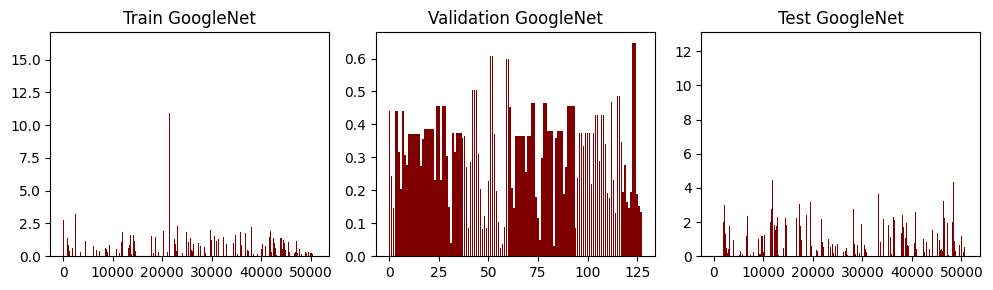

In [ ]:
# Define the sizes of the feature maps
google_size = (224, 224)

# Load the GoogleNet model
google_model = InceptionV3(weights='imagenet', include_top=False)

# Function to compute GoogleNet features for a given image
def compute_GoogleNet(img):
    img = cv2.resize(img, google_size)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input_google(img)
    features = google_model.predict(img)
    features = features.reshape((-1,))
    return features

# Function to compute GoogleNet features for all images in a given folder
def compute_GoogleNet_folder(folder):
    features = []
    labels = []
    for class_folder in os.listdir(folder):
        class_path = os.path.join(folder, class_folder)
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            image = imread(image_path)
            phog_features = compute_GoogleNet(image)
            features.append(phog_features)
            labels.append(class_folder)
    return features, labels



# Compute GoogleNet features for the training set
train_features, train_labels = compute_GoogleNet_folder(train_folder)
train_features = np.array(train_features)
train_labels = np.array(train_labels)

# Compute GoogleNet features for the test set
test_features, test_labels = compute_GoogleNet_folder(test_folder)
test_features = np.array(test_features)
test_labels = np.array(test_labels)

# Compute GoogleNet features for the validation set
val_features, val_labels = compute_GoogleNet_folder(val_folder)
val_features = np.array(val_features)
val_labels = np.array(val_labels)

# Display three random GoogleNet features
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

# Randomly select indices for the test, train, and validation sets
test_idx = np.random.randint(0, len(test_features))
train_idx = np.random.randint(0, len(train_features))
val_idx = np.random.randint(0, len(val_features))

# Display the train GoogleNet
train = train_features[train_idx]
axes[0].bar(range(len(train)), train, color='maroon')
axes[0].set_title('Train GoogleNet')

# Display the validation GoogleNet
val = phog_val_features[val_idx]
axes[1].bar(range(len(val)), val, color='maroon')
axes[1].set_title('Validation GoogleNet')

# Display the test GoogleNet
test = test_features[test_idx]
axes[2].bar(range(len(test)), test, color='maroon')
axes[2].set_title('Test GoogleNet')

plt.tight_layout()
plt.show()

In [ ]:
print("f:",val_features.shape)
print("f:",val_labels.shape)

f: (96, 51200)
f: (96,)


###**Dimensionality Reduction**

In [ ]:
# Function to apply Principal Component Analysis (PCA) for dimensionality reduction
def apply_pca(features, n_components):
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)
    return reduced_features

In [ ]:
# Dimensionality reduction of high level features
reduced_train_features = apply_pca(train_features,n_components=10)
reduced_test_features = apply_pca(test_features,n_components=10)
reduced_val_features = apply_pca(val_features,n_components=10)

# Dimensionality reduction of low level features
reduced_lowLevel_train_Features = apply_pca(lowLevel_train_Features,n_components=10)
reduced_lowLevel_test_Features = apply_pca(lowLevel_test_Features,n_components=10)
reduced_lowLevel_val_Features = apply_pca(lowLevel_val_Features,n_components=10)

# print(reduced_train_features.shape)
# print(reduced_test_features.shape)
# print(reduced_val_features.shape)
# print()
# print(reduced_lowLevel_train_Features.shape)
# print(reduced_lowLevel_test_Features.shape)
# print(reduced_lowLevel_val_Features.shape)

(672, 51200)
(192, 51200)
(96, 51200)
(672, 10)
(192, 10)
(96, 10)

(672, 10)
(192, 10)
(96, 10)
